In [ ]:
# [CLS]トークンを利用

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [ ]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='005'
    debug=False  # False
    wandb=True
    resume=None  # [None, 'auto', 'allow', 'must']
    save_checkpoint=True
    competition='PPPM'
    seed=42

    # Dataset & DataLoader
    tokenizer_kwargs={
        'do_lower_case': True,
    }
    num_workers=4
    batch_size=16
    max_len=512

    # Model
    model="microsoft/deberta-v3-large"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    epochs=4
    gradient_accumulation_steps=1
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [ ]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Fri Jun  3 11:16:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [ ]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
CPU times: user 38.6 ms, sys: 22.1 ms, total: 60.7 ms
Wall time: 2.33 s


In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [ ]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    !pip install -q wandb
    import wandb

    if CFG.debug:
        anony = "must"
        print('It is debugging.')
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    else:
        try:
            # from kaggle_secrets import UserSecretsClient
            # user_secrets = UserSecretsClient()
            # secret_value_0 = user_secrets.get_secret("wandb_api")
            with open('/content/drive/MyDrive/kaggle/wandb') as f:
                wandb_api_key = f.readline().rstrip('\n')
            wandb.login(key=wandb_api_key)
            anony = None
        except:
            anony = "must"
            print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                        name=CFG.exp,
                        config=class2dict(CFG),
                    #  group=CFG.exp,
                        job_type="train",
                        resume=CFG.resume,  # 'auto'
                        anonymous=anony)

wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Library

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
tqdm.pandas()
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [ ]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [ ]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [ ]:
# ';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text

train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)

In [ ]:
# anchor, target, context_text をそれぞれ一文ずつとみなす
# anchorとtarget逆順にも並べる
train['text'] = train['anchor'] + '.' + ' [SEP] ' + train['target'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text'] = test['anchor'] + '.' + ' [SEP] ' + test['target'] + '.' + ' [SEP] '  + test['context_text'] + '.'
train['text_rev'] = train['target'] + '.' + ' [SEP] ' + train['anchor'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text_rev'] = test['target'] + '.' + ' [SEP] ' + test['anchor'] + '.' + ' [SEP] '  + test['context_text'] + '.'
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text,text_rev
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] abatement of pollution. [SEP]...,abatement of pollution. [SEP] abatement. [SEP]...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] act of abating. [SEP] HUMAN N...,act of abating. [SEP] abatement. [SEP] HUMAN N...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] active catalyst. [SEP] HUMAN ...,active catalyst. [SEP] abatement. [SEP] HUMAN ...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] eliminating process. [SEP] HU...,eliminating process. [SEP] abatement. [SEP] HU...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] forest region. [SEP] HUMAN NE...,forest region. [SEP] abatement. [SEP] HUMAN NE...


,id,anchor,target,context,context_text,text,text_rev
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum. [SEP] inorganic photoconductor drum....,inorganic photoconductor drum. [SEP] opc drum....
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,adjust gas flow. [SEP] altering gas flow. [SEP...,altering gas flow. [SEP] adjust gas flow. [SEP...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS. TRANSPORTING. VEHICLES ...,lower trunnion. [SEP] lower locating. [SEP] PE...,lower locating. [SEP] lower trunnion. [SEP] PE...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...,cap component. [SEP] upper portion. [SEP] TEXT...,upper portion. [SEP] cap component. [SEP] TEXT...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation. [SEP] artificial neural ne...,artificial neural network. [SEP] neural stimul...


# EDA

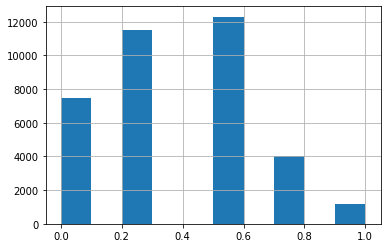

In [ ]:
train['score'].hist()

In [ ]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [ ]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [ ]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [ ]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, **CFG.tokenizer_kwargs)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [ ]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 106


In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, phase: str ='train'):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [ ]:
# train_dataset = TrainDataset(CFG, train, 'train')
# inputs, label = train_dataset[0]
# print(inputs)
# print(label)

# Model

In [ ]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]  # (bs, max_len, hidden_size)
        feature = last_hidden_states[:, 0, :]  # [CLS]トークンを利用
        # feature = torch.mean(last_hidden_states, dim=1)  # 全トークンを平均
        # weights = self.attention(last_hidden_states)
        # feature = torch.sum(weights * last_hidden_states, dim=1)  # 全トークンを全トークンをattentionレイヤで加重平均
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds, phase='train')
    valid_dataset = TrainDataset(CFG, valid_folds, phase='val')

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    if wandb.run.resumed:
        checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['model'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        # amp.load_state_dict(checkpoint['amp'])
        epoch = checkpoint['epoeh'] + 1  # 保存時のエポックが読み出されるので+1
        best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 0 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

Epoch: [1][0/1693] Elapsed 0m 1s (remain 31m 53s) Loss: 0.6560(0.6560) Grad: 202655.6094  LR: 0.00002000  
Epoch: [1][100/1693] Elapsed 1m 18s (remain 20m 41s) Loss: 0.5580(0.6318) Grad: 49640.4336  LR: 0.00001999  
Epoch: [1][200/1693] Elapsed 2m 36s (remain 19m 19s) Loss: 0.6327(0.6201) Grad: 43564.9727  LR: 0.00001996  
Epoch: [1][300/1693] Elapsed 3m 53s (remain 18m 0s) Loss: 0.5742(0.6099) Grad: 25290.9629  LR: 0.00001990  
Epoch: [1][400/1693] Elapsed 5m 10s (remain 16m 41s) Loss: 0.5952(0.6019) Grad: 57806.1094  LR: 0.00001983  
Epoch: [1][500/1693] Elapsed 6m 28s (remain 15m 23s) Loss: 0.4250(0.5928) Grad: 44276.4766  LR: 0.00001973  
Epoch: [1][600/1693] Elapsed 7m 45s (remain 14m 6s) Loss: 0.5958(0.5853) Grad: 25147.3691  LR: 0.00001961  
Epoch: [1][700/1693] Elapsed 9m 3s (remain 12m 48s) Loss: 0.5414(0.5820) Grad: 34964.0273  LR: 0.00001948  
Epoch: [1][800/1693] Elapsed 10m 20s (remain 11m 31s) Loss: 0.6178(0.5798) Grad: 54266.2695  LR: 0.00001932  
Epoch: [1][900/1693] El

Epoch 1 - avg_train_loss: 0.5634  avg_val_loss: 0.5517  time: 1431s
Epoch 1 - Score: 0.8210


EVAL: [586/587] Elapsed 1m 59s (remain 0m 0s) Loss: 0.6880(0.5517) 


Epoch 1 - Save Best Score: 0.8210 Model


Epoch: [2][0/1693] Elapsed 0m 1s (remain 30m 34s) Loss: 0.5417(0.5417) Grad: 141702.5312  LR: 0.00001707  
Epoch: [2][100/1693] Elapsed 1m 20s (remain 21m 10s) Loss: 0.6097(0.5247) Grad: 218854.1250  LR: 0.00001673  
Epoch: [2][200/1693] Elapsed 2m 38s (remain 19m 34s) Loss: 0.4184(0.5237) Grad: 93567.6172  LR: 0.00001638  
Epoch: [2][300/1693] Elapsed 3m 55s (remain 18m 10s) Loss: 0.5993(0.5216) Grad: 163439.9531  LR: 0.00001602  
Epoch: [2][400/1693] Elapsed 5m 13s (remain 16m 49s) Loss: 0.5111(0.5203) Grad: 45812.4453  LR: 0.00001564  
Epoch: [2][500/1693] Elapsed 6m 30s (remain 15m 29s) Loss: 0.5772(0.5198) Grad: 123262.9219  LR: 0.00001525  
Epoch: [2][600/1693] Elapsed 7m 48s (remain 14m 10s) Loss: 0.4897(0.5201) Grad: 71359.8438  LR: 0.00001485  
Epoch: [2][700/1693] Elapsed 9m 5s (remain 12m 51s) Loss: 0.6372(0.5194) Grad: 139271.7969  LR: 0.00001444  
Epoch: [2][800/1693] Elapsed 10m 22s (remain 11m 33s) Loss: 0.6328(0.5209) Grad: 62611.2031  LR: 0.00001402  
Epoch: [2][900/16

Epoch 2 - avg_train_loss: 0.5204  avg_val_loss: 0.5460  time: 1434s
Epoch 2 - Score: 0.8383


EVAL: [586/587] Elapsed 1m 59s (remain 0m 0s) Loss: 0.6785(0.5460) 


Epoch 2 - Save Best Score: 0.8383 Model


Epoch: [3][0/1693] Elapsed 0m 1s (remain 36m 3s) Loss: 0.5447(0.5447) Grad: 51794.4883  LR: 0.00001000  
Epoch: [3][100/1693] Elapsed 1m 20s (remain 21m 2s) Loss: 0.4115(0.5032) Grad: 74961.1016  LR: 0.00000953  
Epoch: [3][200/1693] Elapsed 2m 38s (remain 19m 37s) Loss: 0.5322(0.5029) Grad: 174788.9375  LR: 0.00000907  
Epoch: [3][300/1693] Elapsed 3m 56s (remain 18m 12s) Loss: 0.5260(0.5037) Grad: 35804.3828  LR: 0.00000861  
Epoch: [3][400/1693] Elapsed 5m 13s (remain 16m 50s) Loss: 0.5156(0.5055) Grad: 45733.2812  LR: 0.00000815  
Epoch: [3][500/1693] Elapsed 6m 31s (remain 15m 30s) Loss: 0.5183(0.5045) Grad: 91107.7266  LR: 0.00000770  
Epoch: [3][600/1693] Elapsed 7m 48s (remain 14m 11s) Loss: 0.5063(0.5056) Grad: 92031.3828  LR: 0.00000725  
Epoch: [3][700/1693] Elapsed 9m 5s (remain 12m 52s) Loss: 0.4822(0.5059) Grad: 83603.8906  LR: 0.00000681  
Epoch: [3][800/1693] Elapsed 10m 23s (remain 11m 34s) Loss: 0.4853(0.5082) Grad: 55321.7734  LR: 0.00000637  
Epoch: [3][900/1693] El

Epoch 3 - avg_train_loss: 0.5083  avg_val_loss: 0.5534  time: 1435s
Epoch 3 - Score: 0.8389


EVAL: [586/587] Elapsed 1m 59s (remain 0m 0s) Loss: 0.6747(0.5534) 


Epoch 3 - Save Best Score: 0.8389 Model


Epoch: [4][0/1693] Elapsed 0m 1s (remain 30m 57s) Loss: 0.4012(0.4012) Grad: 26983.9922  LR: 0.00000293  
Epoch: [4][100/1693] Elapsed 1m 20s (remain 21m 3s) Loss: 0.4428(0.5096) Grad: 115071.8281  LR: 0.00000261  
Epoch: [4][200/1693] Elapsed 2m 38s (remain 19m 33s) Loss: 0.5177(0.5043) Grad: 81739.2891  LR: 0.00000230  
Epoch: [4][300/1693] Elapsed 3m 55s (remain 18m 10s) Loss: 0.5466(0.5037) Grad: 33906.8477  LR: 0.00000202  
Epoch: [4][400/1693] Elapsed 5m 13s (remain 16m 49s) Loss: 0.5273(0.5017) Grad: 84022.9297  LR: 0.00000175  
Epoch: [4][500/1693] Elapsed 6m 31s (remain 15m 30s) Loss: 0.5953(0.5023) Grad: 69938.3984  LR: 0.00000149  
Epoch: [4][600/1693] Elapsed 7m 48s (remain 14m 11s) Loss: 0.6515(0.5025) Grad: 50595.7734  LR: 0.00000126  
Epoch: [4][700/1693] Elapsed 9m 6s (remain 12m 53s) Loss: 0.4549(0.5010) Grad: 41744.0938  LR: 0.00000104  
Epoch: [4][800/1693] Elapsed 10m 23s (remain 11m 34s) Loss: 0.3975(0.5006) Grad: 68593.7734  LR: 0.00000085  
Epoch: [4][900/1693] E

Epoch 4 - avg_train_loss: 0.5013  avg_val_loss: 0.5609  time: 1436s
Epoch 4 - Score: 0.8365


EVAL: [586/587] Elapsed 1m 59s (remain 0m 0s) Loss: 0.6764(0.5609) 


========== fold: 0 result ==========
Score: 0.8389
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1725] Elapsed 0m 1s (remain 39m 22s) Loss: 0.6608(0.6608) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1725] Elapsed 1m 20s (remain 21m 33s) Loss: 0.6383(0.6324) Grad: 37329.8242  LR: 0.00001999  
Epoch: [1][200/1725] Elapsed 2m 38s (remain 19m 58s) Loss: 0.5659(0.6181) Grad: 18535.5469  LR: 0.00001996  
Epoch: [1][300/1725] Elapsed 3m 55s (remain 18m 34s) Loss: 0.6230(0.6045) Grad: 47088.9688  LR: 0.00001991  
Epoch: [1][400/1725] Elapsed 5m 13s (remain 17m 13s) Loss: 0.5811(0.5953) Grad: 171382.9219  LR: 0.00001983  
Epoch: [1][500/1725] Elapsed 6m 30s (remain 15m 54s) Loss: 0.5012(0.5894) Grad: 21049.5000  LR: 0.00001974  
Epoch: [1][600/1725] Elapsed 7m 48s (remain 14m 35s) Loss: 0.5411(0.5847) Grad: 34888.9180  LR: 0.00001963  
Epoch: [1][700/1725] Elapsed 9m 5s (remain 13m 17s) Loss: 0.5487(0.5813) Grad: 45201.5000  LR: 0.00001950  
Epoch: [1][800/1725] Elapsed 10m 23s (remain 11m 59s) Loss: 0.4917(0.5768) Grad: 26071.5234  LR: 0.00001934  
Epoch: [1][900/1725] Elapsed

Epoch 1 - avg_train_loss: 0.5615  avg_val_loss: 0.5523  time: 1454s
Epoch 1 - Score: 0.8092


EVAL: [553/554] Elapsed 1m 53s (remain 0m 0s) Loss: 0.5107(0.5523) 


Epoch 1 - Save Best Score: 0.8092 Model


Epoch: [2][0/1725] Elapsed 0m 1s (remain 32m 57s) Loss: 0.4947(0.4947) Grad: 95072.3047  LR: 0.00001707  
Epoch: [2][100/1725] Elapsed 1m 21s (remain 21m 47s) Loss: 0.5849(0.5324) Grad: 92131.8594  LR: 0.00001674  
Epoch: [2][200/1725] Elapsed 2m 38s (remain 20m 4s) Loss: 0.5007(0.5270) Grad: 100540.6562  LR: 0.00001640  
Epoch: [2][300/1725] Elapsed 3m 56s (remain 18m 38s) Loss: 0.5632(0.5264) Grad: 127037.8047  LR: 0.00001604  
Epoch: [2][400/1725] Elapsed 5m 14s (remain 17m 17s) Loss: 0.5092(0.5232) Grad: 80445.1016  LR: 0.00001567  
Epoch: [2][500/1725] Elapsed 6m 31s (remain 15m 56s) Loss: 0.6344(0.5214) Grad: 147300.5781  LR: 0.00001529  
Epoch: [2][600/1725] Elapsed 7m 49s (remain 14m 37s) Loss: 0.3860(0.5212) Grad: 212593.3750  LR: 0.00001490  
Epoch: [2][700/1725] Elapsed 9m 7s (remain 13m 19s) Loss: 0.5843(0.5192) Grad: 64897.1602  LR: 0.00001450  
Epoch: [2][800/1725] Elapsed 10m 24s (remain 12m 0s) Loss: 0.6147(0.5194) Grad: 123065.1016  LR: 0.00001409  
Epoch: [2][900/1725

Epoch 2 - avg_train_loss: 0.5188  avg_val_loss: 0.5615  time: 1455s
Epoch 2 - Score: 0.8147


EVAL: [553/554] Elapsed 1m 53s (remain 0m 0s) Loss: 0.5058(0.5615) 


Epoch 2 - Save Best Score: 0.8147 Model


Epoch: [3][0/1725] Elapsed 0m 1s (remain 38m 0s) Loss: 0.6095(0.6095) Grad: 278407.0938  LR: 0.00001000  
Epoch: [3][100/1725] Elapsed 1m 20s (remain 21m 35s) Loss: 0.4195(0.5138) Grad: 51166.2773  LR: 0.00000955  
Epoch: [3][200/1725] Elapsed 2m 38s (remain 20m 4s) Loss: 0.4689(0.5143) Grad: 73075.4141  LR: 0.00000909  
Epoch: [3][300/1725] Elapsed 3m 56s (remain 18m 38s) Loss: 0.4768(0.5150) Grad: 49596.4531  LR: 0.00000864  
Epoch: [3][400/1725] Elapsed 5m 13s (remain 17m 16s) Loss: 0.4654(0.5158) Grad: 188975.8906  LR: 0.00000819  
Epoch: [3][500/1725] Elapsed 6m 31s (remain 15m 56s) Loss: 0.5555(0.5131) Grad: 46220.9609  LR: 0.00000775  
Epoch: [3][600/1725] Elapsed 7m 49s (remain 14m 37s) Loss: 0.4882(0.5110) Grad: 36244.6758  LR: 0.00000731  
Epoch: [3][700/1725] Elapsed 9m 6s (remain 13m 18s) Loss: 0.5332(0.5116) Grad: 91718.0391  LR: 0.00000687  
Epoch: [3][800/1725] Elapsed 10m 24s (remain 12m 0s) Loss: 0.5020(0.5102) Grad: 21540.9883  LR: 0.00000644  
Epoch: [3][900/1725] El

Epoch 3 - avg_train_loss: 0.5068  avg_val_loss: 0.5544  time: 1455s
Epoch 3 - Score: 0.8276


EVAL: [553/554] Elapsed 1m 53s (remain 0m 0s) Loss: 0.4909(0.5544) 


Epoch 3 - Save Best Score: 0.8276 Model


Epoch: [4][0/1725] Elapsed 0m 1s (remain 32m 28s) Loss: 0.4563(0.4563) Grad: 54825.9219  LR: 0.00000293  
Epoch: [4][100/1725] Elapsed 1m 20s (remain 21m 27s) Loss: 0.6069(0.5015) Grad: 123272.3750  LR: 0.00000262  
Epoch: [4][200/1725] Elapsed 2m 38s (remain 19m 59s) Loss: 0.2918(0.5013) Grad: 46531.8242  LR: 0.00000232  
Epoch: [4][300/1725] Elapsed 3m 55s (remain 18m 35s) Loss: 0.5664(0.5022) Grad: 54063.9414  LR: 0.00000204  
Epoch: [4][400/1725] Elapsed 5m 13s (remain 17m 14s) Loss: 0.4178(0.5026) Grad: 30350.8613  LR: 0.00000177  
Epoch: [4][500/1725] Elapsed 6m 31s (remain 15m 55s) Loss: 0.4878(0.5033) Grad: 24554.8066  LR: 0.00000152  
Epoch: [4][600/1725] Elapsed 7m 48s (remain 14m 36s) Loss: 0.4935(0.5029) Grad: 78278.0234  LR: 0.00000129  
Epoch: [4][700/1725] Elapsed 9m 6s (remain 13m 17s) Loss: 0.4382(0.5023) Grad: 20377.7305  LR: 0.00000107  
Epoch: [4][800/1725] Elapsed 10m 23s (remain 11m 59s) Loss: 0.4969(0.5027) Grad: 43956.0469  LR: 0.00000088  
Epoch: [4][900/1725] 

Epoch 4 - avg_train_loss: 0.4993  avg_val_loss: 0.5628  time: 1454s
Epoch 4 - Score: 0.8252


EVAL: [553/554] Elapsed 1m 52s (remain 0m 0s) Loss: 0.4949(0.5628) 


========== fold: 1 result ==========
Score: 0.8276
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1741] Elapsed 0m 1s (remain 36m 36s) Loss: 0.6979(0.6979) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1741] Elapsed 1m 20s (remain 21m 43s) Loss: 0.7059(0.6641) Grad: 51846.8086  LR: 0.00001999  
Epoch: [1][200/1741] Elapsed 2m 37s (remain 20m 9s) Loss: 0.5683(0.6341) Grad: 39771.8828  LR: 0.00001996  
Epoch: [1][300/1741] Elapsed 3m 55s (remain 18m 46s) Loss: 0.5955(0.6168) Grad: 38548.6445  LR: 0.00001991  
Epoch: [1][400/1741] Elapsed 5m 13s (remain 17m 26s) Loss: 0.6359(0.6043) Grad: 45687.1953  LR: 0.00001984  
Epoch: [1][500/1741] Elapsed 6m 30s (remain 16m 6s) Loss: 0.6195(0.5996) Grad: 39459.9883  LR: 0.00001975  
Epoch: [1][600/1741] Elapsed 7m 48s (remain 14m 48s) Loss: 0.6915(0.5940) Grad: 63089.6328  LR: 0.00001963  
Epoch: [1][700/1741] Elapsed 9m 5s (remain 13m 29s) Loss: 0.5793(0.5888) Grad: 24752.4004  LR: 0.00001950  
Epoch: [1][800/1741] Elapsed 10m 23s (remain 12m 11s) Loss: 0.4595(0.5850) Grad: 27457.7637  LR: 0.00001935  
Epoch: [1][900/1741] Elapsed 11

Epoch 1 - avg_train_loss: 0.5664  avg_val_loss: 0.5418  time: 1463s
Epoch 1 - Score: 0.8298


EVAL: [538/539] Elapsed 1m 49s (remain 0m 0s) Loss: 0.3701(0.5418) 


Epoch 1 - Save Best Score: 0.8298 Model


Epoch: [2][0/1741] Elapsed 0m 1s (remain 39m 22s) Loss: 0.3870(0.3870) Grad: 115634.0938  LR: 0.00001707  
Epoch: [2][100/1741] Elapsed 1m 22s (remain 22m 12s) Loss: 0.5042(0.5203) Grad: 89852.8750  LR: 0.00001674  
Epoch: [2][200/1741] Elapsed 2m 39s (remain 20m 23s) Loss: 0.4947(0.5151) Grad: 76967.9453  LR: 0.00001640  
Epoch: [2][300/1741] Elapsed 3m 57s (remain 18m 55s) Loss: 0.4906(0.5162) Grad: 102970.8125  LR: 0.00001605  
Epoch: [2][400/1741] Elapsed 5m 14s (remain 17m 32s) Loss: 0.3475(0.5137) Grad: 97535.2656  LR: 0.00001568  
Epoch: [2][500/1741] Elapsed 6m 32s (remain 16m 11s) Loss: 0.4734(0.5150) Grad: 37801.3008  LR: 0.00001531  
Epoch: [2][600/1741] Elapsed 7m 50s (remain 14m 52s) Loss: 0.6364(0.5141) Grad: 172139.6875  LR: 0.00001492  
Epoch: [2][700/1741] Elapsed 9m 8s (remain 13m 33s) Loss: 0.5038(0.5153) Grad: 76542.0000  LR: 0.00001452  
Epoch: [2][800/1741] Elapsed 10m 25s (remain 12m 14s) Loss: 0.5390(0.5162) Grad: 46356.0273  LR: 0.00001412  
Epoch: [2][900/1741

Epoch 2 - avg_train_loss: 0.5201  avg_val_loss: 0.5371  time: 1465s
Epoch 2 - Score: 0.8456


EVAL: [538/539] Elapsed 1m 49s (remain 0m 0s) Loss: 0.3400(0.5371) 


Epoch 2 - Save Best Score: 0.8456 Model


Epoch: [3][0/1741] Elapsed 0m 1s (remain 32m 25s) Loss: 0.5759(0.5759) Grad: 127436.4297  LR: 0.00001000  
Epoch: [3][100/1741] Elapsed 1m 20s (remain 21m 52s) Loss: 0.4829(0.5021) Grad: 54748.7695  LR: 0.00000955  
Epoch: [3][200/1741] Elapsed 2m 38s (remain 20m 15s) Loss: 0.5132(0.5063) Grad: 44498.4766  LR: 0.00000910  
Epoch: [3][300/1741] Elapsed 3m 56s (remain 18m 50s) Loss: 0.4898(0.5016) Grad: 100777.3359  LR: 0.00000865  
Epoch: [3][400/1741] Elapsed 5m 13s (remain 17m 28s) Loss: 0.5192(0.5020) Grad: 84284.7734  LR: 0.00000820  
Epoch: [3][500/1741] Elapsed 6m 31s (remain 16m 8s) Loss: 0.4768(0.5032) Grad: 59294.4844  LR: 0.00000776  
Epoch: [3][600/1741] Elapsed 7m 49s (remain 14m 49s) Loss: 0.5775(0.5042) Grad: 65646.5312  LR: 0.00000732  
Epoch: [3][700/1741] Elapsed 9m 6s (remain 13m 30s) Loss: 0.6386(0.5037) Grad: 64467.8125  LR: 0.00000689  
Epoch: [3][800/1741] Elapsed 10m 24s (remain 12m 12s) Loss: 0.6080(0.5054) Grad: 55998.6523  LR: 0.00000647  
Epoch: [3][900/1741] 

Epoch 3 - avg_train_loss: 0.5083  avg_val_loss: 0.5442  time: 1464s
Epoch 3 - Score: 0.8443


EVAL: [538/539] Elapsed 1m 49s (remain 0m 0s) Loss: 0.3364(0.5442) 
Epoch: [4][0/1741] Elapsed 0m 1s (remain 31m 0s) Loss: 0.4380(0.4380) Grad: 51985.3828  LR: 0.00000293  
Epoch: [4][100/1741] Elapsed 1m 20s (remain 21m 43s) Loss: 0.5121(0.4974) Grad: 60653.5938  LR: 0.00000262  
Epoch: [4][200/1741] Elapsed 2m 37s (remain 20m 9s) Loss: 0.5455(0.4993) Grad: 247530.3281  LR: 0.00000232  
Epoch: [4][300/1741] Elapsed 3m 55s (remain 18m 46s) Loss: 0.5304(0.5000) Grad: 89319.0859  LR: 0.00000204  
Epoch: [4][400/1741] Elapsed 5m 13s (remain 17m 25s) Loss: 0.5719(0.5014) Grad: 36220.8633  LR: 0.00000177  
Epoch: [4][500/1741] Elapsed 6m 30s (remain 16m 7s) Loss: 0.4906(0.5009) Grad: 113719.7969  LR: 0.00000153  
Epoch: [4][600/1741] Elapsed 7m 48s (remain 14m 48s) Loss: 0.4563(0.4999) Grad: 63336.2305  LR: 0.00000130  
Epoch: [4][700/1741] Elapsed 9m 5s (remain 13m 29s) Loss: 0.4535(0.5008) Grad: 29664.2246  LR: 0.00000108  
Epoch: [4][800/1741] Elapsed 10m 23s (remain 12m 11s) Loss: 0.581

Epoch 4 - avg_train_loss: 0.5022  avg_val_loss: 0.5494  time: 1464s
Epoch 4 - Score: 0.8436


EVAL: [538/539] Elapsed 1m 50s (remain 0m 0s) Loss: 0.3357(0.5494) 


========== fold: 2 result ==========
Score: 0.8456
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1678] Elapsed 0m 1s (remain 38m 53s) Loss: 0.7233(0.7233) Grad: 323578.5938  LR: 0.00002000  
Epoch: [1][100/1678] Elapsed 1m 20s (remain 20m 59s) Loss: 0.5761(0.6493) Grad: 66626.0938  LR: 0.00001999  
Epoch: [1][200/1678] Elapsed 2m 38s (remain 19m 23s) Loss: 0.5912(0.6292) Grad: 71076.0703  LR: 0.00001996  
Epoch: [1][300/1678] Elapsed 3m 55s (remain 17m 59s) Loss: 0.7070(0.6110) Grad: 32118.7324  LR: 0.00001990  
Epoch: [1][400/1678] Elapsed 5m 13s (remain 16m 38s) Loss: 0.5091(0.6013) Grad: 16445.5957  LR: 0.00001982  
Epoch: [1][500/1678] Elapsed 6m 31s (remain 15m 19s) Loss: 0.5498(0.5953) Grad: 12112.7002  LR: 0.00001973  
Epoch: [1][600/1678] Elapsed 7m 48s (remain 14m 0s) Loss: 0.6043(0.5888) Grad: 25445.1191  LR: 0.00001961  
Epoch: [1][700/1678] Elapsed 9m 6s (remain 12m 41s) Loss: 0.6200(0.5828) Grad: 11767.4375  LR: 0.00001947  
Epoch: [1][800/1678] Elapsed 10m 24s (remain 11m 23s) Loss: 0.4676(0.5779) Grad: 10102.1494  LR: 0.00001931  
Epoch: [1][900/1678] E

Epoch 1 - avg_train_loss: 0.5629  avg_val_loss: 0.5498  time: 1429s
Epoch 1 - Score: 0.8014
Epoch 1 - Save Best Score: 0.8014 Model


Epoch: [2][0/1678] Elapsed 0m 1s (remain 36m 27s) Loss: 0.4852(0.4852) Grad: 49823.0117  LR: 0.00001707  
Epoch: [2][100/1678] Elapsed 1m 21s (remain 21m 6s) Loss: 0.6189(0.5216) Grad: 96624.9766  LR: 0.00001673  
Epoch: [2][200/1678] Elapsed 2m 38s (remain 19m 27s) Loss: 0.5688(0.5187) Grad: 70923.0859  LR: 0.00001638  
Epoch: [2][300/1678] Elapsed 3m 56s (remain 18m 1s) Loss: 0.5450(0.5158) Grad: 31654.7832  LR: 0.00001601  
Epoch: [2][400/1678] Elapsed 5m 14s (remain 16m 40s) Loss: 0.5815(0.5150) Grad: 21114.4375  LR: 0.00001563  
Epoch: [2][500/1678] Elapsed 6m 31s (remain 15m 20s) Loss: 0.5393(0.5167) Grad: 15025.2373  LR: 0.00001523  
Epoch: [2][600/1678] Elapsed 7m 49s (remain 14m 1s) Loss: 0.5735(0.5162) Grad: 12386.7764  LR: 0.00001483  
Epoch: [2][700/1678] Elapsed 9m 7s (remain 12m 42s) Loss: 0.6269(0.5177) Grad: 25236.6094  LR: 0.00001442  
Epoch: [2][800/1678] Elapsed 10m 25s (remain 11m 24s) Loss: 0.5034(0.5177) Grad: 29639.5625  LR: 0.00001399  
Epoch: [2][900/1678] Elap

Epoch 2 - avg_train_loss: 0.5182  avg_val_loss: 0.5563  time: 1430s
Epoch 2 - Score: 0.8109
Epoch 2 - Save Best Score: 0.8109 Model


Epoch: [3][0/1678] Elapsed 0m 1s (remain 42m 21s) Loss: 0.5192(0.5192) Grad: 36097.0039  LR: 0.00001000  
Epoch: [3][100/1678] Elapsed 1m 20s (remain 21m 1s) Loss: 0.5472(0.5082) Grad: 49600.5898  LR: 0.00000953  
Epoch: [3][200/1678] Elapsed 2m 38s (remain 19m 27s) Loss: 0.4319(0.5056) Grad: 49261.3203  LR: 0.00000906  
Epoch: [3][300/1678] Elapsed 3m 56s (remain 18m 3s) Loss: 0.5408(0.5040) Grad: 26045.8984  LR: 0.00000860  
Epoch: [3][400/1678] Elapsed 5m 14s (remain 16m 41s) Loss: 0.4964(0.5030) Grad: 27434.5508  LR: 0.00000813  
Epoch: [3][500/1678] Elapsed 6m 32s (remain 15m 21s) Loss: 0.4307(0.5025) Grad: 16618.4062  LR: 0.00000768  
Epoch: [3][600/1678] Elapsed 7m 49s (remain 14m 2s) Loss: 0.4357(0.5019) Grad: 28175.6250  LR: 0.00000722  
Epoch: [3][700/1678] Elapsed 9m 7s (remain 12m 43s) Loss: 0.4800(0.5028) Grad: 39923.9570  LR: 0.00000678  
Epoch: [3][800/1678] Elapsed 10m 25s (remain 11m 24s) Loss: 0.5963(0.5024) Grad: 19768.9629  LR: 0.00000634  
Epoch: [3][900/1678] Elap

Epoch 3 - avg_train_loss: 0.5031  avg_val_loss: 0.5677  time: 1429s
Epoch 3 - Score: 0.8127
Epoch 3 - Save Best Score: 0.8127 Model


Epoch: [4][0/1678] Elapsed 0m 1s (remain 38m 51s) Loss: 0.5660(0.5660) Grad: 49321.7578  LR: 0.00000293  
Epoch: [4][100/1678] Elapsed 1m 21s (remain 21m 17s) Loss: 0.4182(0.5026) Grad: 28823.7930  LR: 0.00000260  
Epoch: [4][200/1678] Elapsed 2m 39s (remain 19m 31s) Loss: 0.6049(0.5008) Grad: 74845.5234  LR: 0.00000230  
Epoch: [4][300/1678] Elapsed 3m 57s (remain 18m 4s) Loss: 0.4962(0.4985) Grad: 65707.4375  LR: 0.00000201  
Epoch: [4][400/1678] Elapsed 5m 14s (remain 16m 42s) Loss: 0.4299(0.4976) Grad: 67235.0859  LR: 0.00000173  
Epoch: [4][500/1678] Elapsed 6m 32s (remain 15m 21s) Loss: 0.5948(0.4940) Grad: 50773.1719  LR: 0.00000148  
Epoch: [4][600/1678] Elapsed 7m 49s (remain 14m 2s) Loss: 0.5235(0.4946) Grad: 34136.6328  LR: 0.00000124  
Epoch: [4][700/1678] Elapsed 9m 7s (remain 12m 43s) Loss: 0.4125(0.4937) Grad: 16283.9678  LR: 0.00000103  
Epoch: [4][800/1678] Elapsed 10m 25s (remain 11m 24s) Loss: 0.5287(0.4942) Grad: 21612.2266  LR: 0.00000083  
Epoch: [4][900/1678] Ela

Epoch 4 - avg_train_loss: 0.4968  avg_val_loss: 0.5669  time: 1429s
Epoch 4 - Score: 0.8122
========== fold: 3 result ==========
Score: 0.8127
========== CV ==========
Score: 0.8304


[fold0] avg_train_loss,█▃▂▁
[fold0] avg_val_loss,▄▁▄█
[fold0] epoch,▁▃▆█
[fold0] loss,█▇▆█▇▇▇█▇█▅▇▅▅▇▅▄▇▆▇▁█▄▅▅▅▄▇▃▂▆▇▂▆▇▃▁▁▇▄
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁██▇
[fold1] avg_train_loss,█▃▂▁
[fold1] avg_val_loss,▁▇▂█
[fold1] epoch,▁▃▆█
[fold1] loss,█▅▇▆▅▃▅▆▃▁▄▄▄▄▆▁▁▂▆▅▅▄▄▆▃▃▄▄▅▄▃▄▄▂▅▄▄▃▄▁
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


In [ ]:
oof_df.iloc[np.random.default_rng().permutation(np.arange(len(oof_df)))[:10]]

In [ ]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file train.log
100% 2.40k/2.40k [00:02<00:00, 875B/s]
Upload successful: train.log (2KB)
Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:05<00:00, 2.58kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file tokenizer.tar
100% 2.36M/2.36M [00:06<00:00, 402kB/s]
Upload successful: tokenizer.tar (2MB)
Starting upload for file config.pth
100% 2.48k/2.48k [00:03<00:00, 837B/s]
Upload successful: config.pth (2KB)
Starting upload for file microsoft-deberta-v3-large_fold0_best.pth
100% 1.62G/1.62G [00:44<00:00, 39.3MB/s]
Upload successful: microsoft-deberta-v3-large_fold0_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold1_best.pth
100% 1.62G/1.62G [00:38<00:00, 44.8MB/s]
Upload successful: microsoft-deberta-v3-large_fold1_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold2_best.pth
100% 1.62G/1.62G [00:37<00:00, 46.1MB/s]
Upload successful: microsoft-deberta-v3-large_fold2_best.pth (2GB)
Starting upload f